<a href="https://colab.research.google.com/github/BMateusSs/Projeto-PISI3/blob/main/exploraty_analysis_wine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# Importar bibliotecas essenciais
import kagglehub
import pandas as pd
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- Carregamento do Dataset Combinado Diretamente do Kaggle Hub ---
wine_dataset_slug = "ruthgn/wine-quality-data-set-red-white-wine"
wine_file_name = "wine-quality-white-and-red.csv"

df_raw_combined_wine = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    wine_dataset_slug,
    wine_file_name
)

print("DataFrame combinado de Vinhos Tinto e Branco carregado do Kaggle Hub:")
print(df_raw_combined_wine.head())
print("-" * 50)

# --- Salvando para Parquet (Boa prática para reusabilidade e performance) ---
output_dir = "data/processed"
os.makedirs(output_dir, exist_ok=True)
parquet_path = os.path.join(output_dir, "wine-quality-combined.parquet")

df_raw_combined_wine.to_parquet(parquet_path, engine="pyarrow", index=False)
print(f"DataFrame salvo com sucesso em formato Parquet: {parquet_path}")

# --- Carrega o DataFrame a partir do arquivo Parquet processado ---
df_wine = pd.read_parquet(parquet_path)

# --- NOVIDADE: Traduzir a coluna 'type' para português ---
df_wine['type'] = df_wine['type'].replace({'red': 'tinto', 'white': 'branco'})

print("\n--- Primeiras 5 linhas do DataFrame principal (carregado do Parquet, tipo traduzido) ---")
display(df_wine.head()) # Verifique se 'type' agora mostra 'tinto'/'branco'

print("\n--- Informações gerais do DataFrame principal ---")
df_wine.info()

print("\n--- Verificando valores ausentes no DataFrame principal ---")
print(df_wine.isnull().sum())

DataFrame combinado de Vinhos Tinto e Branco carregado do Kaggle Hub:
    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0      

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,branco,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,branco,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,branco,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,branco,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,branco,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6



--- Informações gerais do DataFrame principal ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB

--- Verific

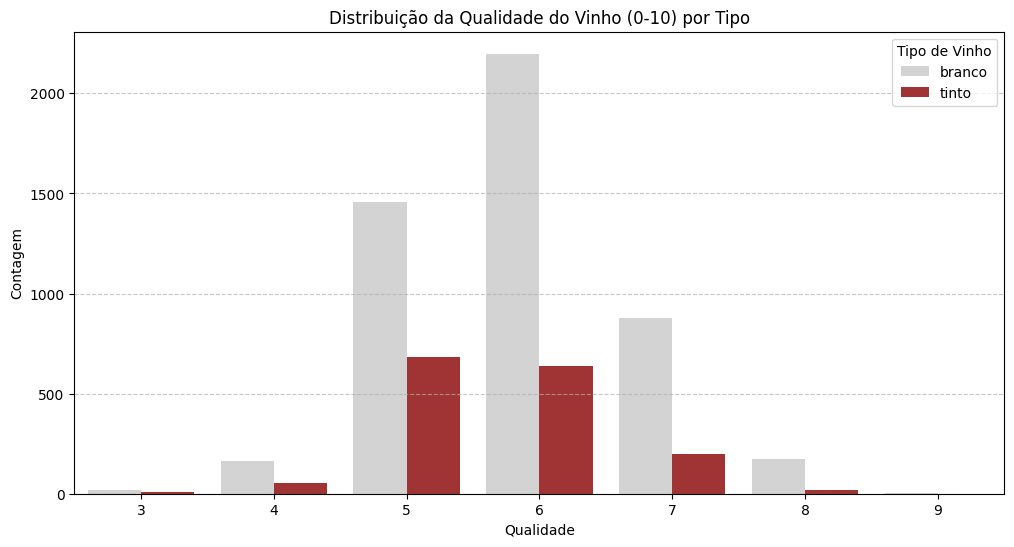

In [40]:
# --- 2.1 Distribuição da Qualidade Original (0-10) por Tipo de Vinho ---
plt.figure(figsize=(12, 6))
# A paleta agora deve usar as chaves em português
custom_type_palette = {'tinto': 'firebrick', 'branco': 'lightgrey'}
sns.countplot(x='quality', data=df_wine, hue='type', palette=custom_type_palette)
plt.title('Distribuição da Qualidade do Vinho (0-10) por Tipo')
plt.xlabel('Qualidade')
plt.ylabel('Contagem')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Tipo de Vinho')
plt.show()

# --- 2.2 Criação da Variável Alvo Binária ('good_quality') para EDA ---
# Definir 'good_quality' para visualização do balanceamento
df_wine['good_quality'] = df_wine['quality'].apply(lambda x: 1 if x >= 6 else 0)

O gráfico ilustra a distribuição das pontuações de qualidade dos vinhos por tipo (tinto e branco). A maioria dos vinhos concentra-se nas qualidades 5, 6 e 7, com poucas amostras nas faixas extremas. O dataset é predominantemente composto por vinhos brancos, que apresentam um pico de contagem nas qualidades 6 e 5. Vinhos tintos, em menor número, também se concentram nessas qualidades, mas com menor representatividade nas faixas superiores em comparação aos brancos. Esta análise reforçou a decisão de transformar a quality em uma variável binária para classificação e a necessidade de técnicas para lidar com o desbalanceamento resultante.

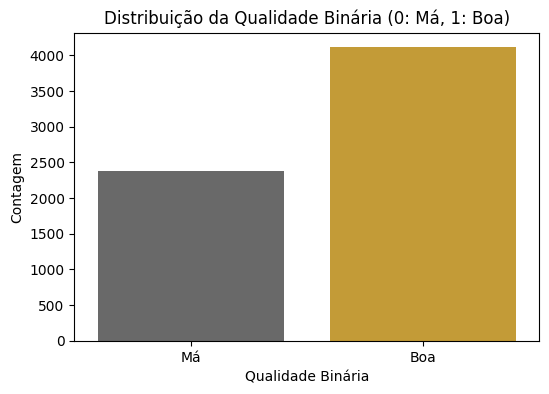

In [41]:
# --- 2.3 Distribuição da Qualidade Binária (0: Má, 1: Boa) ---
plt.figure(figsize=(6, 4))
custom_binary_palette_list = ['dimgray', 'goldenrod']
sns.countplot(x='good_quality', data=df_wine, palette=custom_binary_palette_list)

plt.title('Distribuição da Qualidade Binária (0: Má, 1: Boa)')
plt.xlabel('Qualidade Binária')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Má', 'Boa'])
plt.show()

O gráfico acima ilustra a distribuição dos vinhos após a transformação da variável de qualidade original em uma classificação binária de 'Má' (0) e 'Boa' (1). Conforme observado no gráfico, a classe 'Boa Qualidade' constitui a maioria das amostras, com aproximadamente 4100 vinhos, enquanto a classe 'Má Qualidade' representa a minoria, com cerca de 2400 vinhos. Esta representação visual da proporção de classes no dataset serviu como base para a aplicação de técnicas de balanceamento, como o SMOTE, garantindo que o modelo não fosse enviesado durante o treinamento pela predominância de uma das categorias.

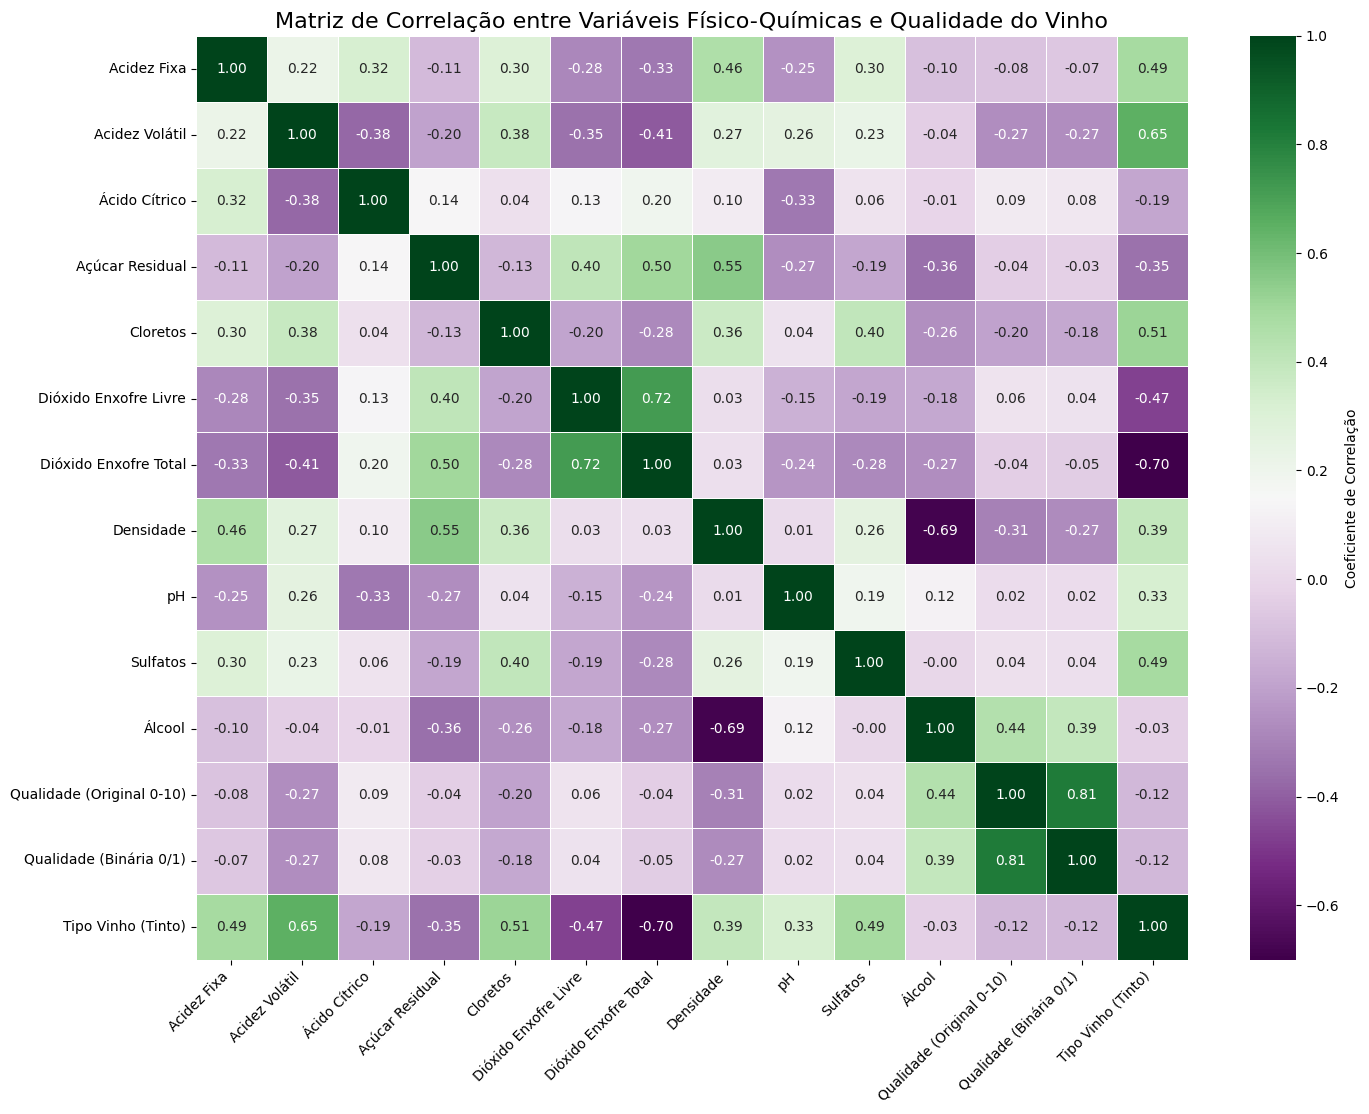


--- Correlações das variáveis (em português) com a Qualidade ---
Qualidade (Binária 0/1)      1.000000
Qualidade (Original 0-10)    0.814484
Álcool                       0.394676
Ácido Cítrico                0.075739
Dióxido Enxofre Livre        0.044819
Sulfatos                     0.035807
pH                           0.018842
Açúcar Residual             -0.032484
Dióxido Enxofre Total       -0.047585
Acidez Fixa                 -0.067354
Tipo Vinho (Tinto)          -0.116595
Cloretos                    -0.181908
Acidez Volátil              -0.267046
Densidade                   -0.268876
Name: Qualidade (Binária 0/1), dtype: float64


In [42]:
# --- 3.1 Matriz de Correlação entre Variáveis e Qualidade (Aprimorada) ---

# Mapeamento de nomes de colunas de Inglês para Português
column_translation = {
    'fixed acidity': 'Acidez Fixa',
    'volatile acidity': 'Acidez Volátil',
    'citric acid': 'Ácido Cítrico',
    'residual sugar': 'Açúcar Residual',
    'chlorides': 'Cloretos',
    'free sulfur dioxide': 'Dióxido Enxofre Livre',
    'total sulfur dioxide': 'Dióxido Enxofre Total',
    'density': 'Densidade',
    'pH': 'pH',
    'sulphates': 'Sulfatos',
    'alcohol': 'Álcool',
    'quality': 'Qualidade (Original 0-10)',
    'good_quality': 'Qualidade (Binária 0/1)',
}

# Criar uma cópia do DataFrame e realizar One-Hot Encoding para 'type'
df_corr_plot = df_wine.copy()
df_corr_plot = pd.get_dummies(df_corr_plot, columns=['type'], drop_first=True, dtype=int)

# Renomear 'type_tinto' para português se existir
if 'type_tinto' in df_corr_plot.columns:
    column_translation['type_tinto'] = 'Tipo Vinho (Tinto)'
elif 'type_branco' in df_corr_plot.columns: # Caso o One-Hot Encoding gere 'type_branco'
    column_translation['type_branco'] = 'Tipo Vinho (Branco)'

df_corr_plot.rename(columns=column_translation, inplace=True)

# Calcular a matriz de correlação no DataFrame com colunas renomeadas
correlation_matrix_portuguese = df_corr_plot.corr()

# --- NOVIDADE: Aumentar o tamanho da figura e usar paleta de cores 'PRGn' ---
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix_portuguese, annot=True, cmap='PRGn', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Coeficiente de Correlação'})
# 'PRGn' (Purple-Green) é uma paleta divergente onde o VERDE indica correlação positiva
# e o ROXO/MAGENTA indica correlação negativa. Isso evita o uso de vermelho para positivo.
plt.title('Matriz de Correlação entre Variáveis Físico-Químicas e Qualidade do Vinho', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

print("\n--- Correlações das variáveis (em português) com a Qualidade ---")
print(correlation_matrix_portuguese['Qualidade (Binária 0/1)'].sort_values(ascending=False))

O gráfico apresenta a matriz de correlação de Pearson entre todas as características físico-químicas, o tipo de vinho e as variáveis de qualidade tanto original quanto a binária). O mapa de calor utiliza uma paleta de cores onde tons esverdeados indicam correlação positiva e tons arroxeados representam correlação negativa, com um centro neutro.

Analisando a correlação com a Qualidade (Binária 0/1), nossa variável alvo, observa-se que o Álcool possui a correlação positiva mais forte, sugerindo que vinhos com maior teor alcoólico tendem a ser classificados como de 'Boa Qualidade'. Em contraste, Densidade, Dióxido de Enxofre Total e Acidez Volátil apresentam as correlações negativas mais expressivas, indicando que níveis mais elevados dessas características estão associados à 'Má Qualidade'.


--- Box Plots das Features Mais Importantes (selecionadas da correlação) ---


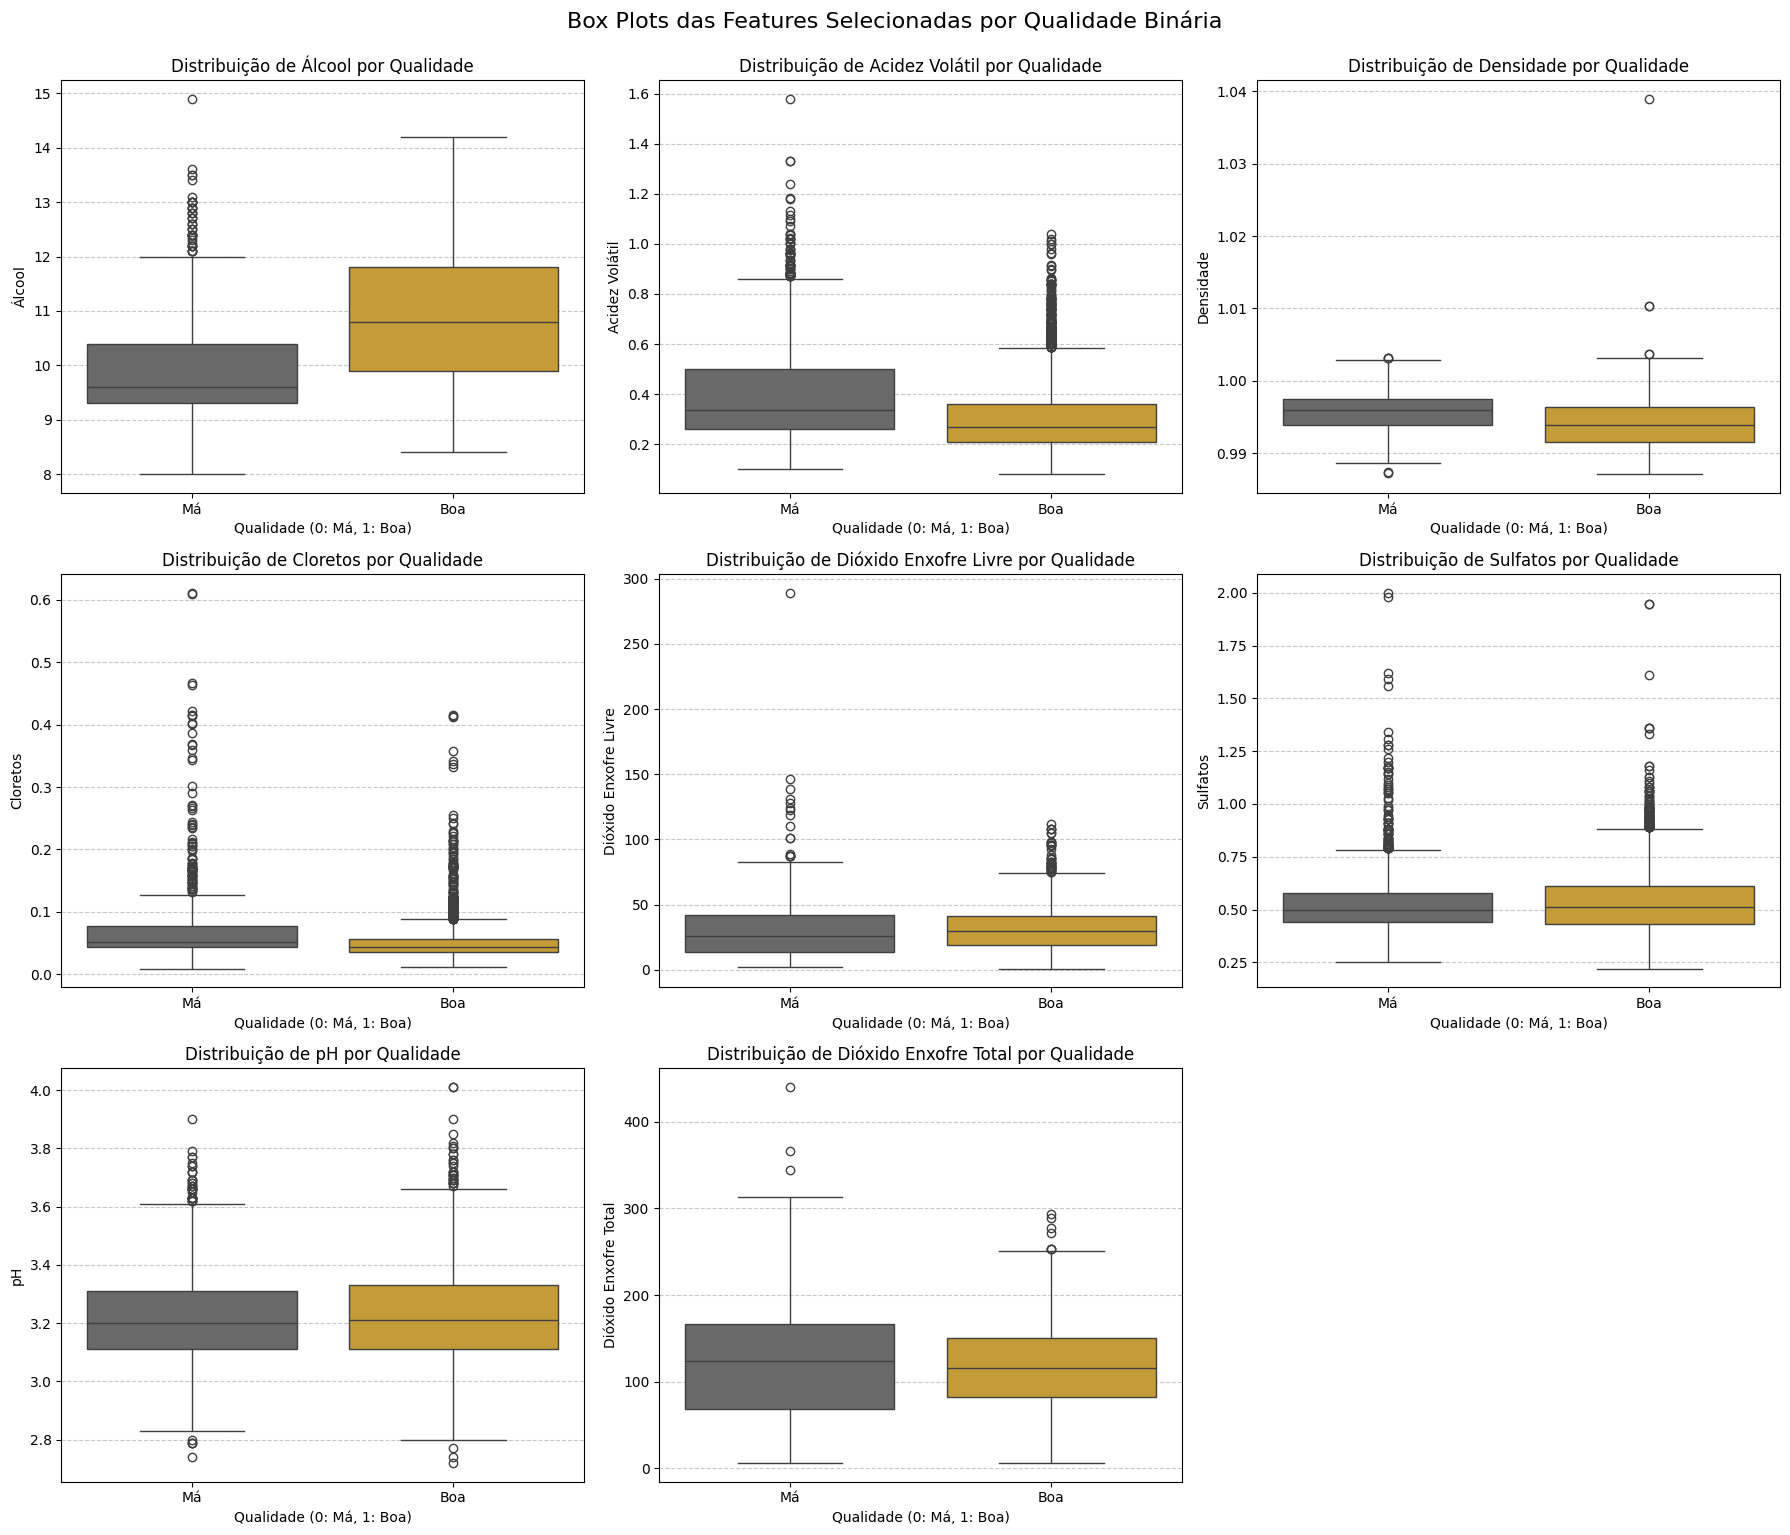

In [43]:
# --- 4.1 Seleção das Features para Box Plots ---
# Com base na matriz de correlação, selecionamos as features que geralmente são mais importantes.
top_eda_features = [
    'alcohol',
    'volatile acidity',
    'density',
    'chlorides',
    'free sulfur dioxide',
    'sulphates',
    'pH',
    'total sulfur dioxide',
]

print(f"\n--- Box Plots das Features Mais Importantes (selecionadas da correlação) ---")

# --- CORREÇÃO: Redefinir paletas e dicionário de tradução para garantir acessibilidade nesta célula ---
# Isso resolve o NameError e o ValueError para a paleta binária.
custom_binary_palette_list = ['dimgray', 'goldenrod'] # AGORA É UMA LISTA para boxplot/kdeplot
column_translation = {
    'fixed acidity': 'Acidez Fixa', 'volatile acidity': 'Acidez Volátil', 'citric acid': 'Ácido Cítrico',
    'residual sugar': 'Açúcar Residual', 'chlorides': 'Cloretos',
    'free sulfur dioxide': 'Dióxido Enxofre Livre', 'total sulfur dioxide': 'Dióxido Enxofre Total',
    'density': 'Densidade', 'pH': 'pH', 'sulphates': 'Sulfatos', 'alcohol': 'Álcool',
    'quality': 'Qualidade (Original 0-10)', 'good_quality': 'Qualidade (Binária 0/1)',
    'type_tinto': 'Tipo Vinho (Tinto)', # Assumindo este nome do OHE
    'type_branco': 'Tipo Vinho (Branco)' # Se por acaso for esse o nome da coluna OHE
}


# --- 4.2 Gerar Box Plots ---
plt.figure(figsize=(18, 15))
for i, feature in enumerate(top_eda_features):
    plt.subplot(3, 3, i + 1)
    # Usar o dicionário column_translation para obter o nome em português da feature
    translated_feature_name = column_translation.get(feature, feature.replace("_", " ").title())
    sns.boxplot(x='good_quality', y=feature, data=df_wine, palette=custom_binary_palette_list) # Usando a LISTA

    plt.title(f'Distribuição de {translated_feature_name} por Qualidade')
    plt.xlabel('Qualidade (0: Má, 1: Boa)')
    plt.ylabel(translated_feature_name)
    plt.xticks(ticks=[0, 1], labels=['Má', 'Boa'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle('Box Plots das Features Selecionadas por Qualidade Binária', y=1.02, fontsize=16)
plt.show()

O gráfico apresenta a distribuição de características físico-químicas selecionadas por qualidade binária ('Má' e 'Boa'), usando tons azulados para 'Má' e alaranjados para 'Boa'. Observa-se que Álcool e Acidez Volátil são fortes discriminadores: vinhos 'Boa Qualidade' possuem álcool consistentemente mais alto e acidez volátil significativamente mais baixa. Densidade e Cloretos também mostram tendências mais baixas para vinhos 'Boa Qualidade', indicando seu poder discriminatório. Características como Dióxido Enxofre Livre e Sulfatos exibem maior sobreposição, com menor capacidade de separação individual das classes. Esta análise visual complementa a identificação das features mais relevantes para a classificação da qualidade do vinho.